# Learning from data 2018 - Project 2

## Instructions

| Date set     | Hand-in date |
|------------------|-----------------------------------|
|13th November 2018  | **12:00 3rd December 2018** |



Candidate number: 031831

Your report should consist of your Jupyter notebook showing what you did (including technical descriptions of the implemented algorithms), what was the result and what you can conclude from the experiments. Each report will be
assessed on the following criteria:

* Does it record what was done including the details of the implemented algorithms?
* Does it permit the results to be reproduced?
* How does the work relate to the theoretical foundations discussed in lectures?
* Is it well presented?

Use markdown to explain what you are doing (including equations, if any), what the results mean, how they relate to the theory, etc.

You can add new cells as you think fit and delete ones that are not needed (do not delete this preamble). 

### Submitting the notebooks

Only an electronic submissions is required.  Submit your notebook (the .ipynb file) to electronic copy via the  [electronic hand-in system](http://empslocal.ex.ac.uk/submit/) using the topic:
- <cmd>2018-12-03~ECM3420~Lorenzo Livi~cw2</cmd>
- <cmd>2018-12-03~ECMM445~Lorenzo Livi~cw2</cmd>

You should be able to upload the notebook directly from wherever it is on your machine.  If you're not sure where it is, type <code>pwd</code> (print working directory) in a cell to find out.  To keep the marking anonymous, please don't leave directory names that reveal your identity in cells.

<div class="alert alert-warning">
Although you will undoubtedly work collaboratively in the workshops themselves, these are *individual* exercises.  The reports you write should be about the results *you* obtained, and your attention is drawn to the College and University guidelines on collaboration and plagiarism. 

## Project specification

The project consists of two parts, each one worth 5% of the total 10% associated with this assessed workshop.

- **First part of the project**

Implement a standard echo state network (ESN) model. Do not include feedback from the output and do not include leaking neurons. Implement training of the read-out by solving a standard regularized least-square problem. Perform some preliminary simulations by considering a _k_ step ahead forecasting task (evaluate several values of *k* as forecasting horizon) on the "2sine" time series and describe the experimental results.
    
- **Second part of the project**

Implement a version of the ESN model that is trained online by means of the least-mean-square algorithm. Perform simulations to compare the performance on a k step ahead forecasting task with respect to the standard ESN implementation (first part of the project). In the experiments, take into account multiple _k_ values for the forecasting horizon (i.e., explore the effects of increasing *k* on the performance) and process the "2sine" and "lorenz" time series provided in the archive.

## Your project starts from here!

In [2]:
# make sure plots are displayed correctly on notebooks
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Part 1 of the project...

#### Import data

Length of data set = 2000


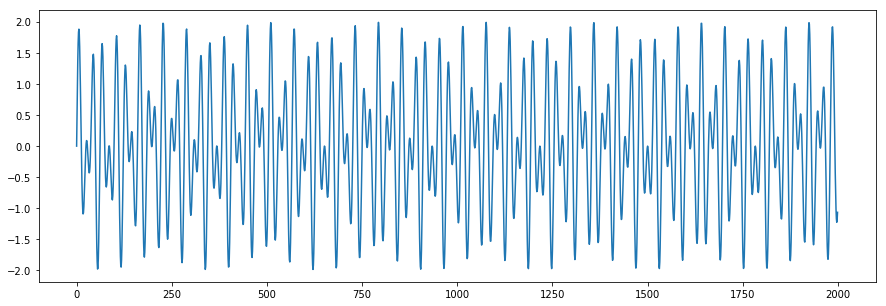

In [3]:
def getData():
    return genfromtxt("./2sin",delimiter=",")

figure(figsize=(15,5))
X = getData()
print("Length of data set =",len(X))
plot(X)
plt.show()

#### What is an Echo State Network?

An Echo State Network is an example of a reservoir computing. By having a large reservoir of untrained, randomly generated, neurons (relative to the input), and training only the weights related to the output, allows these sparse random connections to "echo" previous elements from the time series, allowing it to mimic the pattern of previously trained upon data, should the system recieve a similar input.

The standard formula for Echo State Networks, without feedback from outputs, follows as:

\begin{align*}
x_t = \phi(W^rx_t{_-{_1}} + W^{in}u_t + \epsilon)\text{,}
\end{align*}
\begin{align*}
y_t = W^{out}x_t
\end{align*}

Where $W^r$ and $W^{in}$ are randomly initialized.

#### Generate $W^{in}$

$W^i$, where $W^{in} \in \mathbb{R}^{N_r \times N_i{_n}}$, has each of it's elements randomized from a uniform distribution of $[-1,1]$. While not mentioned in the lecture notes, most papers talk about the sparsity of $W^{in}$, by having a large number of the element of $W^{in}$ equal zero. While in general sparse connections are slated to give better performances, M. Lukosevicius discusses in his 2012 paper *A Practical Guide to Applying Echo State Networks* how slight this increased performance is, giving sparsity the least importance among all hyper-parameters.

In [4]:
def GenerateWi(Nr, Nin, sparsity = 0):
    ### Args:
    ###   Nr is the number of neurons in the recurrent layer
    ###   Nin is the number of input neurons
    ###   sparsity is the percentage of elements turned to zero
    
    out = np.random.uniform(low = -1.0, high = 1.0, size = (Nr,Nin))
    
    ## ADDS ZERO ELEMENTS TO Win TO MAKE IT A SPARSE MATRIX
    if(sparsity != 0):
        sN = int(sparsity * Nr * Nin)
        sNr = np.random.randint(0, Nr,  sN)
        sNi = np.random.randint(0, Nin, sN)
        for i in range(sN):
            out[sNr[i],sNi[i]] = 0
        
    return out

##### Generate $W^r$
As the resulting values of $W^r$, where $W^r \in \mathbb{R}^{N_r \times N_r}$, have a direct effect on how the algorithm functions, they method of randomly generating $W^r$ is not one set method. One method, described in the lecture notes, $W^r$ is assigned by a uniform distribution over $[-1,1]$, scaled to match the spectral radius $a \approx 1$, where $W^r =  a\frac{W^r}{\rho(W^r)}$ and $\rho(W^r)$ is the spectral radius of $W^r$. Large values of $\rho(W^r)$ will cause the echo state property, that defining feature of an echo state network, to fail/be violated. Hence the value of $a$ is used to scale it to $\approx 1$ where this echo state property is most likely to hold.

In [5]:
def GenerateWrUniform(Nr, a, sparsity = 0):
    ### Args:
    ###   Nr is the number of neurons in the recurrent layer
    ###   a is a hyper-parameter to control the generation of W^r
    
    W = np.random.uniform(low = -1.0, high = 1.0, size = (Nr,Nr))
    
    ## ADDS ZERO ELEMENTS TO Win TO MAKE IT A SPARSE MATRIX
    if(sparsity != 0):
        sN = int(sparsity * Nr * Nr)
        sNr1 = np.random.randint(0, Nr,  sN)
        sNr2 = np.random.randint(0, Nr, sN)
        for i in range(sN):
            W[sNr1[i],sNr2[i]] = 0
    
    Wrho = np.max(np.abs(np.linalg.eigvals(W)))
    return a * (W / Wrho)

Another method described in the lecture notes for creating the initial value of $W^r$ is to have a gaussian distribution $\mathcal{N}(0,g^2\textit{/}N_r)$, where $g \approx 1$ is another hyper parameter, similar to $a$.

In [6]:
def GenerateWrGaussian(Nr, g):
    ### Args:
    ###   Nr is the number of neurons in the recurrent layer
    ###   g is a hyper-parameter to control the generation of W^r
    
    W = np.random.normal(loc = 0.0, scale = g**2 / Nr, size = (Nr, Nr))
    return W

Methods suggested outside of the lecture notes include deterministic models such as Cycle Reservoir with Jumps (CRJ) as suggested by A. Rodan and P. Tino in their paper $\text{Simple Deterministically Constructed Cycle Reservoirs with Regular Jumps}$. In the CRJ model, rather than all of weights being individually random, the value of $W^r$ instead has the diagonal $W^r_{i+1,i} = r_c$, for $i = 1...N-1$ and $W^r_{1,N} = r_c$ to give a cyclical value for the weights so each of the neurons in the recurrent layer effects the next in order. Additionally there are jump entries in $W^r$ where, in the case of having the recurrent neurons in a cycle, starting from the first neuron, every $\lambda$ neurons are also linked (with a non-zero weight) by the value of $r_j$. These connectins are bi-directional. $\lambda$ is another hyper-parameter. How this is represented is shown below.

Additionally CRJs also have an alternate $W^i$ to compensate for these changes, where rather than being randomly determined, the values are once again deterministic and are the set absolute value of $v$. In the paper the sign of $v$ is changed based on the value of the related digit of $\pi$ for each value of $W^i$, where $0\leq$digit$\leq4$ has the sign of $v$ be -, and for all other cases, +. Rather than implement this method, I simply had it randomly decide. $r^c$, $\lambda$, $r^j$, and $v$ are all hyper-parameters to be determined.

![title](Image/CRJ.png)

In [7]:
def GenerateWrCRJ(Nr, rc, rj, l):
    ### Args:
    ###   Nr is the number of neurons in the recurrent layer
    ###   rc is the hyper-parameter for the weight value between the cycle
    ###   rj is the hyper-parameter for the weight value between jumps
    ###   l is the hyper-parameter for length of jumps
    
    W = np.zeros((Nr, Nr))
    for i in range(Nr-1):
        W[i+1,i] = rc
    W[0,Nr - 1] = rc
    for i in range(Nr // l):
        j = (i * l) % Nr
        k = ((i + 1) * l) % Nr
        W[j,k] = rj
        W[k,j] = rj
    return W
        
        
        
def GenerateWiCRJ(Nr, Nin, v, sparsity = 0):
    ### Args:
    ###   Nr is the number of neurons in the recurrent layer
    ###   Nin is the number of neurons in the input layer
    ###   v is the hyper-parameter for the absolute value of each element
    ###   sparsity is the percentage of elements turned to zero
    
    from random import random        
    
    Wi = np.full((Nr,Nin),v)
    
    for i in range(Nr):
        for j in range(Nin):
            if (random() < 0.5):
                Wi[i,j] *= -1
    
    ## ADDS ZERO ELEMENTS TO Win TO MAKE IT A SPARSE MATRIX
    if(sparsity != 0):
        sN = int(sparsity * Nr * Nin)
        sNr = np.random.randint(0, Nr,  sN)
        sNi = np.random.randint(0, Nin, sN)
        for i in range(sN):
            out[sNr[i],sNi[i]] = 0
        
    return Wi

#### Training
To train the network to a forecasting task, we parse the input and have the output be the value k-steps ahead, giving the task of $\{u_i,t_i\}^N_{i=1}$ where $t_i$ is k steps ahead of $u_i$. $u_i$ in the case of this task in $m$ ordered elements from the data. 

##### Data Split
Splitting the data into $m$ sized sections within array $U$, along with the related targets of each in $t$

In [8]:
def splitDataAll(data, m, k):
    ### Args:
    ###   data is time series to be split into values of u_i
    ###   m is the length of each subset
    ###   k is number of steps before target
    
    
    data = np.array(data)
    n = np.shape(data)[0] - m - k
    try:
        U = np.zeros((n , m, np.shape(data)[1]))
        t = np.zeros((n , np.shape(data)[1]))
    except:
        U = np.zeros((n , m))
        t = np.zeros((n , 1))
    for i in range(len(data) - m - k):
        for j in range(m):
            U[i][j] = data[i+j]
        t[i] = data[i + m + k - 1]
    return U, t

In [9]:
def fit(Wr, Win, xt0, u):
    ### Args:
    ###   Wr is the matrix of random weights within the reservoir layer
    ###   Win is the matrix of random weight from the input layer
    ###   xt0 is the previous/current state being updated
    ###   u is the value of the input layer    
    
    pre = np.dot(Wr,xt0) + np.dot(Win,u)
    #eps = (np.random.normal(scale = 0.001)) ## RANDOM GUASSIAN ERROR
    eps = np.random.uniform(low = 0, high = 0.001)
    return np.tanh(pre) + eps ## = xt

##### Error Function
The tasks asks us to implement a regularized-least-squares error function. For fitting this isn't used, however for evalutating the error of the tests within the experimentation section, this will be used. Defined as:

\begin{align*}
E(y,y^{target}) = \frac{1}{n}\sum_{i=1}^{n}{(y^{target}_{i}-y_{i})^2}
\end{align*}

In [10]:
def error(y, yt):
    ### Args:
    ###   y is the output being tested
    ###   yt is the target output being tested aginst
    
    n = shape(y)[0]
    eps = 0
    for i in range(n):
        eps += (yt[i] - y[i])**2
    return eps/n

###### Ridge Regression
As $y_t = W^{out}x_{t}$, and hence $Y = W^{out} X$, we get $W^{out} = ((X^TX + \lambda^2I)^{-1} X^Tt)^T$, where $X$ is the collected N states of $x_i$, $t$ is all the related targets, and $\lambda \geq 0$ is the regularisation parameter, as seen in the lecture notes. This can, however, just be changed to the more straightforward $W^{out} = Y X^{+}$ where $X^{+}$ is the psuedoinverse of $X$.

In [11]:
def ridgeReg(X, t):
    ### Args:
    ###   X is the collected N states of xi
    ###   t is all of the target related to xi
    
    out = np.dot(np.linalg.pinv(X),t)
    return out

#### Echo State Network Function
The complete ESN function follows the process described at the start of this section. The learning takes the input of $m$ points from the times series to find the value of the times series $k$ steps in the future.

   1 Generate $W^r$ and $W^{in}$
   <br>2 Split the data into $i$ sections of length $m$ with target $y_i$, $k$ steps ahead of the last element
   <br>3 Initialize the first state, $x_0$, of the "echo" as matrix or zeroes, length $N^r$
   <br>4 Pass through each part of the data through the network, finding the state as it leaves
   <br>5 With array of all the states, find $W^{out}$ through some means
   <br>6 Using $W^{out}$ forecast future values of the time series
    

In [12]:
def ESN(data, m, k, Nr = 200, a = 0.95, trainpercent = 0.9):
    ### Args:
    ###   data to be analysed
    ###   m is hyper-parameter for data splitting. Equal to Nin
    ###   k is hyper-parameter for k-steps forecasting
    ###   Nr represents size of reservoir
    ###   a is hyper-parameter for the generation of Wr
    ###   trainpercent is percentage of data used to train/test
    
    Wi = GenerateWi(Nr, m, sparsity = 0.3)
    Wr = GenerateWrUniform(Nr, a, sparsity = 0.3)
    
    U, t = splitDataAll(data[0:int(len(data)* trainpercent)], m, k) 
    
    X = np.zeros((len(U), Nr))
    for n in range(1,len(U)):
        X[n,:] = fit(Wr, Wi, X[n-1,:], U[n,:])
        
    Wo = ridgeReg(X,t)
    return Wo, Wr, Wi, X[-1]

#### Forecasts from $W^{out}$

##### Only Initial Data
ForecastStart is supplied with a section of the actual data and from that predicts a number of values into the future to compare against the acutual data and further. No further values are given to base predictions on, it simply uses older predicitions to predict further and further into the future.

In [13]:
def ForecastStart(data, Wr, Wi, lastState, m, k, trainpercent = 0.9, extendIterations = 100, quiet = False):
    ### Args:
    ###   data used for the ESN
    ###   Wr generated by the ESN
    ###   Wi generated by the ESN
    ###   lastState is final value of X before finding Wo
    ###   m, hyper-parameter used by ESN
    ###   k, hyper-parameter used by ESN
    ###   trainpercent is percentage of data used to train/test the ESN
    
    dita = data[round(len(data)* trainpercent) - (m + k - 1) : round(len(data)* trainpercent)]
    itera = round(len(data)* (1 - trainpercent)) + 1000
    Xn = lastState
    for i in range(itera):
        Un = dita[i:i + m]
        Xn = fit(Wr, Wi, Xn, Un)
        yn = Wo.T@Xn
        dita = np.append(dita,yn)        
    yt = data[round(len(data)* trainpercent): round(len(data)* trainpercent)+itera+m+k]
    err = error(dita[m+k-1:round(len(data)*(1-trainpercent)) - 2], yt)
    
    if not quiet:
        figure(figsize=(15,5))
            
        plot(np.linspace(m+k-1,m+k + round(len(data)* (1 - trainpercent)) - 2,
                    round(len(data)* (1 - trainpercent))),data[round(len(data)* trainpercent):
                    round(len(data)* trainpercent)+itera+m+k])
        plot(dita)
    
        plot(data[round(len(data)* trainpercent) - (m + k - 1): round(len(data) * trainpercent)])
        legend(["Validation Data","Forecast Data","Initial Data"])
        title("Forecasting Far Into the Future With Only the Starting Data Given")
        print("Error (far forecast) =",err)
        
    return err

##### Given Data
In ForecastEach, rather than relying on the previously forecast/generated data to predict further but instead takes actual testing data. In essensce it is only predicting k-steps in the future rather than using several iterations of predicting k-steps ahead to forecast far in the future.

In [14]:
def ForecastEach(data, Wr, Wi, lastState, m, k, trainpercent = 0.9, quiet = False):
    ### Args:
    ###   data used for the ESN
    ###   Wr generated by the ESN
    ###   Wi generated by the ESN
    ###   lastState is final value of X before finding Wo
    ###   m, hyper-parameter used by ESN
    ###   k, hyper-parameter used by ESN
    ###   trainpercent is percentage of data used to train/test the ESN
    
    dita = data[round(len(data)* trainpercent) - (m + k - 1) : round(len(data)* trainpercent)]
    itera = round(len(data)* (1 - trainpercent)) + k
    U = data[round(len(data)*trainpercent) - (m + k - 1): round(len(data)* trainpercent) + itera]
    Xn = lastState
    for i in range(itera):
        Un = U[i:i + m]
        Xn = fit(Wr, Wi, Xn, Un)
        yn = Wo.T@Xn
        dita = np.append(dita,yn)        
    
    yt = data[round(len(data)* trainpercent): round(len(data)* trainpercent)+itera+m+k]
    err = error(dita[m+k-1:round(len(data)*(1-trainpercent)) - 2], yt)
    
    if not quiet:
        figure(figsize=(15,5))
        
    
        plot(np.linspace(m+k-1,m+k + round(len(data)* (1 - trainpercent)) - 2,
                    round(len(data)* (1 - trainpercent))), yt)
    
        plot(dita)    
        
        plot(data[round(len(data)* trainpercent) - (m + k - 1): round(len(data) * trainpercent)])
        legend(["Testing Data","Forecasted Data","End of Training Data"])
        title("Forecasting k-Steps Only, Each Input is From Testing Data")
        print("Error (k-steps) =",err)
    
    return err

See below for an example of both forms working well. In this example, we have a large value of both $m$, the number of values inputted for each forecast, and $k$, the number of time steps ahead being forecasted. In the first plot we have the example of forecasting using previous forecasts as the data for the current, in other words "far future forecasting". With low values of $m$ and $k$ any error present will cause an exponentially increasing effect. This is explored later on. The second version, where each iteration has data from the testing set only, is much more versatile, able to have lower values of $m$ and $k$ as the error is not fed back into the input.

Error (far forecast) = 6.195980660452438e-05
Error (k-steps) = 3.5918914877125356e-05


3.5918914877125356e-05

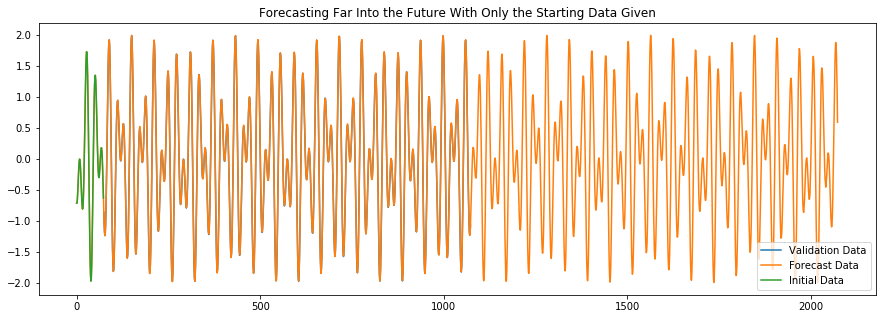

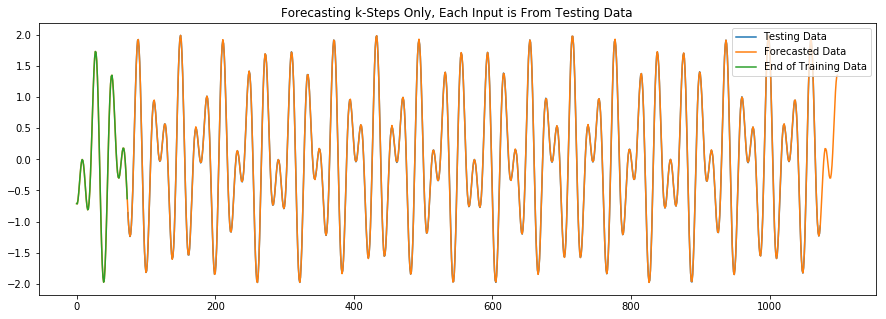

In [90]:
data = getData()
m = 50
k = 25
tp = 0.5

Wo, Wr, Wi, lastState = ESN(data, m, k,Nr = 200, a = 0.85, trainpercent = tp)
ForecastStart(data, Wr, Wi, lastState, m, k, trainpercent = tp, extendIterations = 1000)
ForecastEach(data, Wr, Wi, lastState, m, k, trainpercent = tp)

#### Experiments on the Forecasting Horizon with Varying Values of $k$
Evaluating the error using the previously stated method, the following pair of functions evaluate a range of values for $k$. In this test $m$, is set at the same value of 15, the split of training and testing data is 50%, and, for each value of $k$, the algorihm is ran 5 times and the average error found.

##### Far Forecast
The results from this algorithm show an almost periodic pattern of results, with a large spike at $k \approx 5$ and $k \approx 80$ with a shallow at $k \approx 50$.

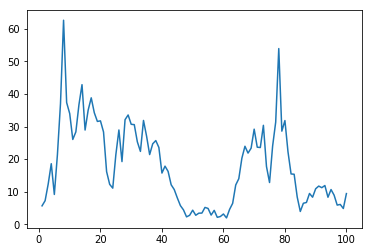

In [165]:
data = getData()
errs = []
tp = 0.5
m = 15

for k in range(1,101):
    toteErr = 0
    for i  in range(5):
        Wo, Wr, Wi, lastState = ESN(data, m, k,Nr = 200, a = 0.85, trainpercent = tp)
        toteErr += ForecastStart(data, Wr, Wi, lastState, m, k, trainpercent = tp, extendIterations = 0, quiet = True)
    errs.append(toteErr / 5)
    
plot(np.linspace(1,100,100),errs)

##### k-Steps Ahead
Exploring the effect of changing without the exploding error of the far forecast gives results that are of a similar pattern but no where near the same scale. As seen the maximum error of this test was around 0.0005, compared to the maximum value of 60 in the far forecasting, that's a 120,000 times difference.

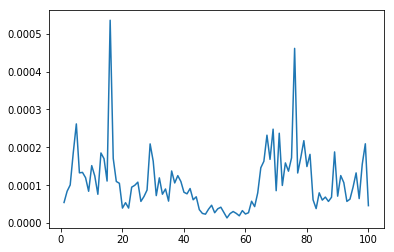

In [164]:
data = getData()
errs = []
tp = 0.5
m = 15

for k in range(1,101):
    toteErr = 0
    for i  in range(5):
        Wo, Wr, Wi, lastState = ESN(data, m, k,Nr = 200, a = 0.85, trainpercent = tp)
        toteErr += ForecastEach(data, Wr, Wi, lastState, m, k, trainpercent = tp, quiet = True)
    errs.append(toteErr / 5)
    
plot(np.linspace(1,100,100),errs)

#### Experiments on the Forecasting Horizon with Varying Values of $m$
To extend the previous experiments, the value of $m$, another hyper-parameter, can be explored to see how it changes the effectiveness of the echo state network. $m$ represents the number of inputs for each state. Increasing the number helps the algorithm learn the overall pattern of the system and decrease the chance of sudden, unpredicted, spikes and other incorrect fluctuations. The tests will use a value of $k = 20$, a value shown to be a good choice in the previous experiment. As with the previous experiment, there will be 5 trials for each value of m, before being averaged.

###### Far Forecast
The error of the function is immense with low values of $m$, however is decreases quickly to a near zero error at $m \approx 20$

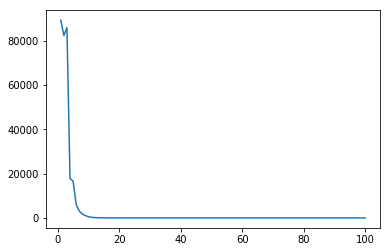

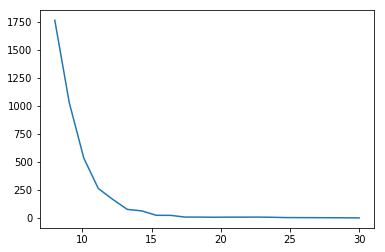

In [23]:
data = getData()
errs = []
tp = 0.5
k = 20

for m in range(1,101):
    toteErr = 0
    for i  in range(5):
        Wo, Wr, Wi, lastState = ESN(data, m, k,Nr = 200, a = 0.85, trainpercent = tp)
        toteErr += ForecastStart(data, Wr, Wi, lastState, m, k, trainpercent = tp, extendIterations = 0, quiet = True)
    errs.append(toteErr / 5)
 
figure(222)
plot(np.linspace(1,100,100),errs)
figure(221)
plot(np.linspace(8,30,22),errs[7:29])

##### k-Steps Ahead
The results of this experiment is very similar, hittting a point where it no longer improves very quickly, however doing so at a better rate. Rather than $20$, no improvement is seen beyond $m \approx 10$.

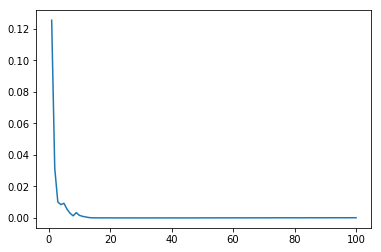

In [16]:
data = getData()
errs = []
tp = 0.5
k = 20

for m in range(1,101):
    toteErr = 0
    for i  in range(5):
        Wo, Wr, Wi, lastState = ESN(data, m, k,Nr = 200, a = 0.85, trainpercent = tp)
        toteErr += ForecastEach(data, Wr, Wi, lastState, m, k, trainpercent = tp, quiet = True)
    errs.append(toteErr / 5)
    
plot(np.linspace(1,100,100),errs)

#### Results
From the results of both experiments the ideal value of $(m,k)$ is $\approx (50,25)$.

### Part 2 of the project...

#### Import Data

Length of data set = 16384


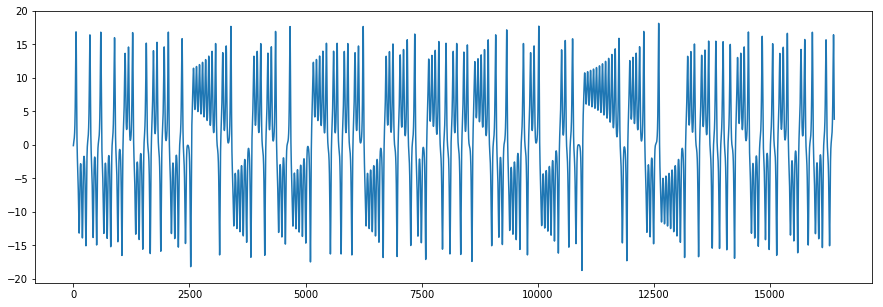

In [15]:
def getDataL():
    return genfromtxt("./lorenz",delimiter=",")

figure(figsize=(15,5))
X = getDataL()
print("Length of data set =",len(X))
plot(X)
plt.show()

#### Online Training
Online training is different, where the output weights are updated after every input, rather than solely after passing through all data. By iteratively updating the solution, it can converge to a single ideal solution for $W^{out}$. The general form of the online training method has $W^{out}(k+1) = W^{out}(k) + \mu(k) g(k)$. In the case of gradient descent, $g(k)$, which represents the direction of learning, is the negative orthogonal matrix of $W^{out}(k)$, providing a value sloping in the direction of steepest descent towards the ideal. As the contours of the horizon of $W^{out}$ will not be consistently smooth, the travel down is guided by the value of $\mu(k)$, the learning rate of the algorithm. This will lie in the closed half-closed region $(0,1]$. Common values are usually $\approx 0.001$.

For least-mean-square algorithm, the gradient vector, $g(k)$, is equal to $-x(k) e(k)$, where $e(k)$ is equal to $t(k) - x(k)\cdot W^{out}(k)$. This gives the update rule of:

\begin{align*}
W^{out}(k+1) = W^{out} + \mu x(k)( t(k) - x(k) \cdot W^{out}(k))
\end{align*}

Implementing that into the ESN algorithm is done below:

In [16]:
def ESNOnline(data, m, k, Nr = 200, a = 0.95, trainpercent = 0.9, g = 0.001, randOrd = False):
    ### Args:
    ###   data to be analysed
    ###   m is hyper-parameter for data splitting. Equal to Nin
    ###   k is hyper-parameter for k-steps forecasting
    ###   Nr represents size of reservoir
    ###   a is hyper-parameter for the generation of Wr
    ###   trainpercent is percentage of data used to train/test
    ###   g is hyper-parameter for the learning rate of the LMS algorithm
    
    Wi = GenerateWi(Nr, m, sparsity = 0.5)
    Wr = GenerateWrUniform(Nr, a, sparsity = 0.5)
    
    U, t = splitDataAll(data[0:int(len(data)* trainpercent)], m, k)
    
    if randOrd:
        n = np.random.permutation(shape(U)[0])
        U = U[n]
        t = t[n]
    
    X = np.zeros((len(U), Nr))
    Wo = np.zeros(Nr)
    
    for n in range(1,len(U)):        
        Xn = fit(Wr, Wi, X[n-1,:], U[n,:])
        X[n,:] = Xn
        e = t[n,:] - Wo@Xn
        Wo = Wo + g*Xn*e
        
    return Wo, Wr, Wi, X[-1]

While not outstandingly different to the batch training implemented in part one, the online training has several advantages. While not necessarily converging to a lower residual error, it allows for a more adaptive method of training the system.

Below is an example of the network being fit to the Lorenz data-set.

Error (k-steps) = 0.27402023306345974


0.27402023306345974

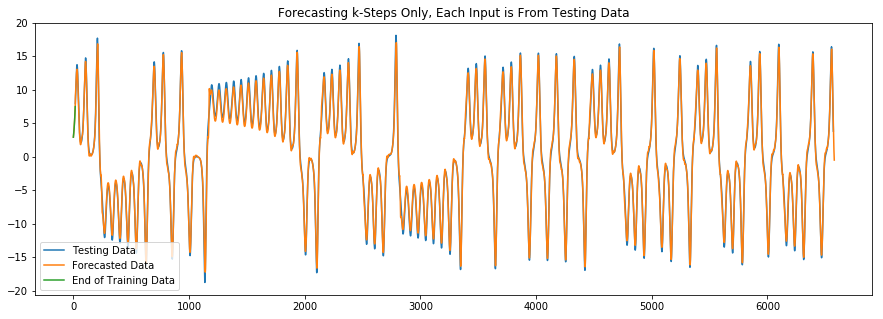

In [110]:
data = getDataL()
m = 10
k = 8
tp = 0.6

Wo, Wr, Wi, lastState = ESNOnline(data, m, k,Nr = 500, a = 0.85, trainpercent = tp, randOrd = True)
ForecastEach(data, Wr, Wi, lastState, m, k, trainpercent = tp)

#### Experimentation

Exploring the forecasting space of online training for varying values of $k$, below is a general overview comparing batch to online training for both 2sine and lorenz dataset across a wide range of $k$ values.

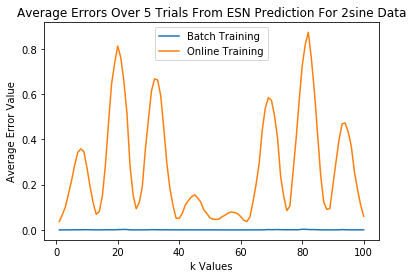

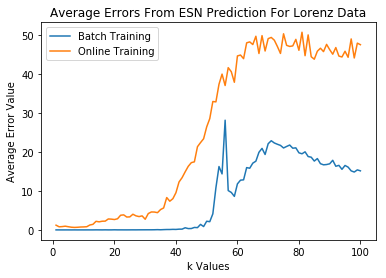

In [114]:
data = getData()
errs = []
errsO = []

dataL = getDataL()
errsL = []
errsOL = []

tp = 0.5
m = 10

for k in range(1,101):
    toteErr = 0
    for i  in range(5):
        Wo, Wr, Wi, lastState = ESN(data, m, k,Nr = 200, a = 0.85, trainpercent = tp)
        toteErr += ForecastEach(data, Wr, Wi, lastState, m, k, trainpercent = tp, quiet = True)
    errs.append(toteErr / 5)
    
for k in range(1,101):
    toteErr = 0
    for i  in range(5):
        Wo, Wr, Wi, lastState = ESNOnline(data, m, k,Nr = 200, a = 0.85, trainpercent = tp)
        toteErr += ForecastEach(data, Wr, Wi, lastState, m, k, trainpercent = tp, quiet = True)
    errsO.append(toteErr / 5)
    
for k in range(1,101):
    toteErr = 0
    for i  in range(5):
        Wo, Wr, Wi, lastState = ESN(dataL, m, k,Nr = 200, a = 0.85, trainpercent = tp)
        toteErr += ForecastEach(dataL, Wr, Wi, lastState, m, k, trainpercent = tp, quiet = True)
    errsL.append(toteErr / 5)
    
for k in range(1,101):
    toteErr = 0
    for i  in range(5):
        Wo, Wr, Wi, lastState = ESNOnline(dataL, m, k,Nr = 200, a = 0.85, trainpercent = tp)
        toteErr += ForecastEach(dataL, Wr, Wi, lastState, m, k, trainpercent = tp, quiet = True)
    errsOL.append(toteErr / 5)
    
figure(222)   
plot(np.linspace(1,100,100),errs)
plot(np.linspace(1,100,100),errsO)
title("Average Errors Over 5 Trials From ESN Prediction For 2sine Data")
xlabel("k Values")
ylabel("Average Error Value")
legend(["Batch Training","Online Training"])
figure(221)
plot(np.linspace(1,100,100),errsL)
plot(np.linspace(1,100,100),errsOL)
title("Average Errors From ESN Prediction For Lorenz Data")
xlabel("k Values")
ylabel("Average Error Value")
legend(["Batch Training","Online Training"])

The results from the online training tests for 2sine, similar to batch training, had the worst performance at $k \approx 20$ and $80$ with the best value around $50$. For the Lorenz data, both online and batch training are similar in accuracy, starting off well, and progressively getting worse/ larger error.

For both the 2sinze and the Lorenz data the batch training shows a significant imporvement over the online training, however online training has other hyper-parameters it can adapt, including the learning rate. Changing this value effects the update functions rate of convergence. Below are tests for the optimal value of the learning rate. As shown, the lower the value of the learning rate, the better the performance of the algorithm.

Text(0, 0.5, 'Average Error Value')

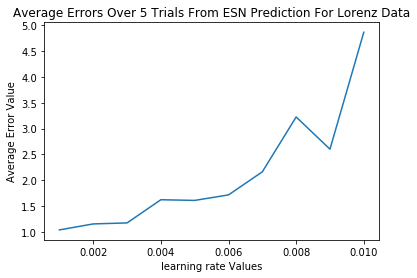

In [22]:
errs = []
data = getDataL()

tp = 0.5
m = 10
k = 10

for gn in np.linspace(0.001,0.01,10):
    toteErr = 0
    for i  in range(5):
        Wo, Wr, Wi, lastState = ESNOnline(data, m, k,Nr = 200, a = 0.85, trainpercent = tp, g = gn)
        toteErr += ForecastEach(data, Wr, Wi, lastState, m, k, trainpercent = tp, quiet = True)
    errs.append(toteErr / 5)
     
plot(np.linspace(0.001,0.01,10),errs)
title("Average Errors Over 5 Trials From ESN Prediction For Lorenz Data")
xlabel("learning rate Values")
ylabel("Average Error Value")